## Load HIV dataset

In [43]:
import pandas as pd
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [44]:
df = pd.read_csv("HIV.csv")
df.head()

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0


In [45]:
string = df.loc[0,'smiles']
print(df.loc[0,'smiles'])
print(string[3])

CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)=[O+]2
1


In [46]:
df.value_counts("activity")

activity
CI    39684
CM     1039
CA      404
Name: count, dtype: int64

In [47]:
df.value_counts("HIV_active")

HIV_active
0    39684
1     1443
Name: count, dtype: int64

## Sampling 

In [58]:
# Separate the dataframe into three categories
df_CI = df[df['activity'] == 'CI']
df_CM = df[df['activity'] == 'CM']
df_CA = df[df['activity'] == 'CA']

# Sampling from each category
sample_CI = df_CI.sample(n=1, random_state=42) 
sample_CM = df_CM.sample(n=1, random_state=42)
sample_CA = df_CA.sample(n=1, random_state=42)

# Concatenate the samples back into one DataFrame
sampled_sf = pd.concat([sample_CI, sample_CM, sample_CA])

# Shuffle the combined DataFrame
sampled_sf = sampled_sf.sample(frac=1, random_state=42).reset_index(drop=True)
sampled_sf

,smiles,activity,HIV_active
0,O=C1c2ccccc2-c2nc3ccccc3nc21,CI,0
1,CC(C)C1NC(=O)C(Cc2ccccc2)NC(=O)C2NC(=O)C(Cc3cc...,CM,1
2,O=S1(=O)CC(O)C(O)CS1,CA,1


O=C1c2ccccc2-c2nc3ccccc3nc21


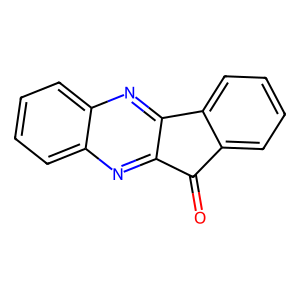

In [59]:
from rdkit import Chem
from rdkit.Chem import Draw
import networkx as nx

smiles = sampled_sf['smiles'].iloc[0]
print(smiles)

# Visualizing the first molecule's structure as an example
mol = Chem.MolFromSmiles(smiles)
Draw.MolToImage(mol)

## Transform SMILES into Graph representation

In [60]:
from torch_geometric.data import Data

# Atom and bond preprocessing functions
def atom_features(atom):
    return [
        atom.GetAtomicNum(),             # Atomic number
        atom.GetFormalCharge(),          # Formal charge
        atom.GetDegree(),                # Degree of the atom
        int(atom.GetHybridization()),    # Hybridization
        atom.GetIsAromatic(),            # Aromaticity
        atom.GetImplicitValence(),       # Implicit valence
        atom.GetMass(),                  # Atomic mass 
        atom.GetTotalDegree(),           # Total number of bonds
        atom.GetTotalValence(),          # Total valence electrons
    ]

def bond_features(bond):
    bt = bond.GetBondType()
    return [
        int(bt == Chem.rdchem.BondType.SINGLE),
        int(bt == Chem.rdchem.BondType.DOUBLE),
        int(bt == Chem.rdchem.BondType.TRIPLE),
        int(bt == Chem.rdchem.BondType.AROMATIC),
        bond.GetIsConjugated(),  # Conjugation
        bond.IsInRing(),         # Whether the bond is in a ring
    ]

In [61]:
# Padding 
def normalize_features(features, max_length):
    """Normalize feature list to a specific length."""
    feature_length = len(features[0])
    if len(features) < max_length:
        # Pad with zeros if there are not enough features
        features += [[0] * feature_length] * (max_length - len(features))
    return [item for sublist in features for item in sublist][:max_length * feature_length]

In [75]:
def smiles_to_graph(smiles, radius=2, max_neighbors=10):
    """Convert SMILES to graph data with consistent node features."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    mol = Chem.AddHs(mol)
    atoms = mol.GetAtoms()
    bonds = mol.GetBonds()

    # Initialize fingerprints
    fingerprint_dict = {atom.GetIdx(): atom_features(atom) for atom in atoms}

    # Weisfeiler-Lehman iteration to update fingerprints
    for _ in range(radius):
        new_fingerprint_dict = {}
        for atom in atoms:
            idx = atom.GetIdx()
            neighbors = [bond.GetOtherAtomIdx(idx) for bond in atom.GetBonds()]
            neighbor_fingerprints = [fingerprint_dict[neighbor] for neighbor in neighbors]
            # Normalize the length of fingerprints
            flat_fingerprint = normalize_features([fingerprint_dict[idx]] + neighbor_fingerprints, max_neighbors)
            new_fingerprint_dict[idx] = flat_fingerprint
        fingerprint_dict = new_fingerprint_dict
        #print(fingerprint_dict)

    # Convert fingerprints to tensors
    node_feats = [fingerprint_dict[atom.GetIdx()] for atom in atoms]
    print(node_feats)
    node_feats = torch.tensor(node_feats, dtype=torch.float)

    # Edge index and attributes remain the same
    edge_index = []
    edge_attr = []
    for bond in bonds:
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append([i, j])
        edge_index.append([j, i])
        edge_features = bond_features(bond)
        edge_attr.append(edge_features)
        edge_attr.append(edge_features)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    return Data(x=node_feats, edge_index=edge_index, edge_attr=edge_attr)


# Apply the function to your dataframe
sampled_sf['graph'] = sampled_sf['smiles'].apply(smiles_to_graph)
print(len(sampled_sf['graph'].iloc[2].x))
#sampled_sf

[[8, 0, 1, 3, False, 0, 15.999, 1, 2, 6, 0, 3, 3, False, 0, 12.011, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 3, 3, False, 0, 12.011, 3, 4, 8, 0, 1, 3, False, 0, 15.999, 1, 2, 6, 0, 3, 3, True, 0, 12.011, 3, 4, 6, 0, 3, 3, True, 0, 12.011, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

## GNN

In [11]:
for i, data in enumerate(sampled_sf['graph']):
    data.y = torch.tensor([sampled_sf['HIV_active'][i]], dtype=torch.long)
print(sampled_sf['graph'][0])

Data(x=[47, 900], edge_index=[2, 98], edge_attr=[98, 6], y=[1])


In [12]:
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader 

sampled_sf = sampled_sf.reset_index(drop=True)
# Split data into training and testing sets
train_dataset, val_dataset = train_test_split(sampled_sf['graph'].tolist(), test_size=0.2, random_state=42)

# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [13]:
import torch.optim as optim
from tqdm import tqdm
from torch.nn import Linear, ReLU, Sequential
from torch_geometric.utils import scatter
from torch_geometric.loader import DataLoader as GraphDataLoader

class Layer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.layers = Sequential(
            Linear(in_dim, out_dim),
            ReLU()
        )
    
    def forward(self, x):
        return self.layers(x)

class MessagePassingLayer(nn.Module):
    def __init__(self, node_hidden_dim, edge_hidden_dim):
        super().__init__()
        self.edge_net = Layer(2 * node_hidden_dim + edge_hidden_dim, edge_hidden_dim)
        self.node_net = Layer(node_hidden_dim + edge_hidden_dim, node_hidden_dim)
    
    def forward(self, node_features, edge_features, edge_index):
        src, dest = edge_index[0], edge_index[1]
        edge_features_combined = torch.cat([
            node_features[src],
            node_features[dest],
            edge_features
        ], dim=1)
        updated_edge_features = self.edge_net(edge_features_combined)
        aggr_edge_features = scatter(updated_edge_features, src, dim_size=node_features.size(0))
        node_features_combined = torch.cat([node_features, aggr_edge_features], dim=1)
        updated_node_features = self.node_net(node_features_combined)
        return updated_node_features, updated_edge_features

class GraphNet(nn.Module):
    def __init__(self, node_input_dim, edge_input_dim, node_hidden_dim, edge_hidden_dim, num_classes):
        super().__init__()
        self.node_embed = Layer(node_input_dim, node_hidden_dim)
        self.edge_embed = Layer(edge_input_dim, edge_hidden_dim)
        self.message_passing = MessagePassingLayer(node_hidden_dim, edge_hidden_dim)
        self.readout = Linear(node_hidden_dim, num_classes)
    
    def forward(self, data):
        node_hidden = self.node_embed(data.x)
        edge_hidden = self.edge_embed(data.edge_attr)
        node_hidden, edge_hidden = self.message_passing(node_hidden, edge_hidden, data.edge_index)
        graph_embeddings = scatter(node_hidden, data.batch, dim=0)
        out = self.readout(graph_embeddings)
        return out

In [26]:
from sklearn.metrics import confusion_matrix

class GNNTrainer:
    def __init__(self, model, batch_size=32, learning_rate=1e-3, epoch=10, l2=1e-5):
        self.model = model
        
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        
        self.batch_size = batch_size
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)
        self.epoch = epoch
        
    def train(self, train_loader, draw_curve=True):  
        self.model.train()
        loss_func = nn.CrossEntropyLoss()
        batch_loss_list = []
        for i in range(self.epoch):
            print(f"Epoch: {i}")
            for batch_data in tqdm(train_loader, leave=False):
                self.optimizer.zero_grad()
                batch_pred = self.model(batch_data)  # Assume model handles the batch_data correctly
                batch_loss = loss_func(batch_pred, batch_data.y)
                batch_loss.backward()
                self.optimizer.step()

                batch_loss_list.append(batch_loss.item())
        
        if draw_curve:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.set_yscale("log")
            ax.plot(np.arange(len(batch_loss_list)), batch_loss_list)
            ax.set_xlabel("# Batch")
            ax.set_ylabel("Loss")
            plt.show()
        
        return batch_loss_list
    
    def evaluate(self, val_loader, draw_curve=True):
        self.model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for batch_data in tqdm(val_loader, leave=False):
                batch_pred = self.model(batch_data)
                y_pred.extend(batch_pred.argmax(dim=1).cpu().numpy())
                y_true.extend(batch_data.y.cpu().numpy())
        
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        accuracy = np.mean(y_true == y_pred)
        
        if draw_curve:
            cm = confusion_matrix(y_true, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
            plt.title("Confusion Matrix")
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.show()
            
        return accuracy

In [30]:
num_classes = 2  # HIV_active: 0 1
node_input_dim = sampled_sf['graph'][0].x.shape[1] 
edge_input_dim = sampled_sf['graph'][0].edge_attr.shape[1]  
node_hidden_dim = 64
edge_hidden_dim = 64
model = GraphNet(node_input_dim, edge_input_dim, node_hidden_dim, edge_hidden_dim, num_classes)

GraphNet - Number of parameters: 78850
Epoch: 0


Epoch: 1


Epoch: 2


Epoch: 3


Epoch: 4


Epoch: 5


Epoch: 6


Epoch: 7


Epoch: 8


Epoch: 9


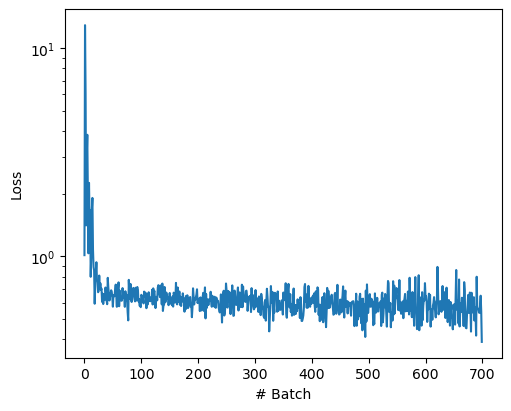

[1.014083981513977,
 12.916954040527344,
 6.048416614532471,
 1.410049557685852,
 3.001156806945801,
 3.841230869293213,
 2.1017515659332275,
 1.035057783126831,
 2.255655288696289,
 1.5449488162994385,
 1.6700661182403564,
 0.7979691028594971,
 1.0286370515823364,
 1.680158019065857,
 1.9101636409759521,
 1.080834984779358,
 0.8898873925209045,
 0.8557829260826111,
 0.592505931854248,
 0.7401072978973389,
 0.8398666381835938,
 0.9377704858779907,
 0.7687764763832092,
 0.7609592080116272,
 0.6727874875068665,
 0.6832244992256165,
 0.8092842698097229,
 0.6974174976348877,
 0.7426177859306335,
 0.689702033996582,
 0.7011939287185669,
 0.6047356724739075,
 0.6619992256164551,
 0.5906568765640259,
 0.6347529888153076,
 0.6578240990638733,
 0.6193329691886902,
 0.708975613117218,
 0.6635149717330933,
 0.6113969087600708,
 0.5894745588302612,
 0.7891181111335754,
 0.7075420022010803,
 0.6597294807434082,
 0.6142877340316772,
 0.6404181122779846,
 0.6582889556884766,
 0.6876056790351868,
 0.6

In [31]:
trainer = GNNTrainer(model)
trainer.train(train_loader)

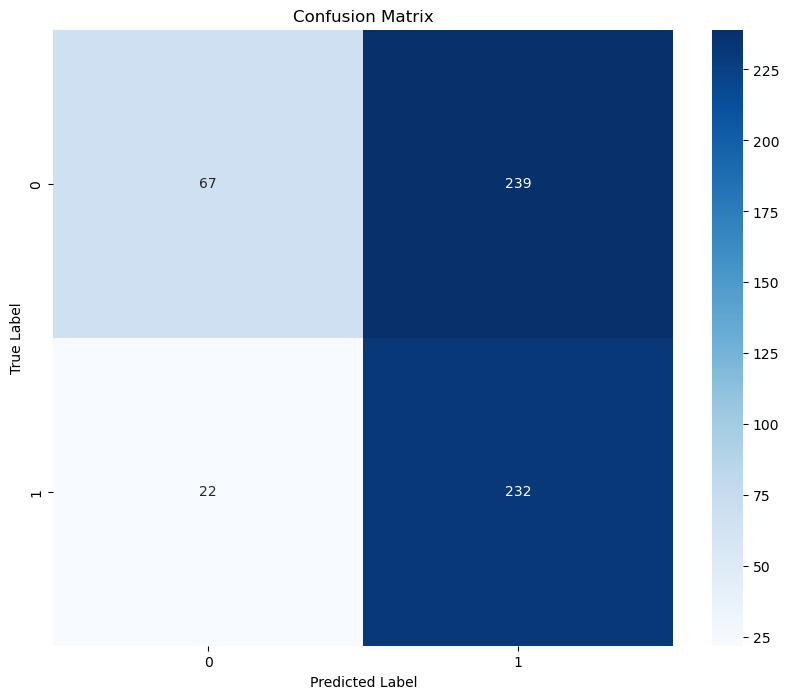

0.5339285714285714

In [32]:
# evaulate
trainer.evaluate(val_loader)